In [2]:
%load_ext autoreload
%autoreload 2

import sys, pickle
sys.path.append('/home/andy/Documents/Research/software/basecode/')
from importscript import *

import tqdm
no_warnings()

## Modelling $G$ flux scatter.

The flux measurement error is given by photon count noise:
$$N_F \sim \frac{\mu_F \exp(-\mu_F)}{N_F!}$$

Assuming large numbers of photons are used, this can be approximated as Gaussian flux error:
$$F \sim \mathcal{N}(\mu_F, \sigma_F^2)$$

When multiple measurements contribute to the mean flux measure, the posterior flux distribution is given by
$$ \mathrm{P}(\mu_F) = \prod_{i=1}^{N} \mathcal{N}(F_i, \sigma_{Fi}^2) \\
 = \mathcal{N} \left(\left(\sum_{i=1}^{N} \frac{1}{\sigma_{Fi}^2}\right)\sum_{i=1}^{N} \frac{F_i}{\sigma_{Fi}^2}, \sum_{i=1}^{N} \frac{1}{\sigma_{Fi}^2})\right).$$
 
Therefore the eventual flux error is given by
$$ \epsilon_F = \left(\sum_{i=1}^{N} \frac{1}{\sigma_{Fi}^2}\right)^{-\frac{1}{2}}.$$

Assuming all measurements of a given source have the same flux error
$$ \epsilon_F \approx \frac{\sigma_{F}}{\sqrt{N}}$$

The scatter of measured flux is given by:
$$ \delta^2 = \frac{1}{N}\sum_{i=1}^{N} (F_i - \mu_F)$$

Whilst the reduced sum-of-square residuals is drawn from a chi-square distribution
$$\sum_{i=1}^{N} \frac{(F_i-\mu_F)}{\sigma_F} \sim \chi^2(N).$$

Putting these together and substituting in $\epsilon_F$ we get
$$\frac{1}{\epsilon_F^2} \sim \frac{\chi^2(N)}{\delta^2}\\
\sim \Gamma\left(\frac{N}{2}, \frac{\delta^2}{2}\right).$$

The good news here is that the likelihood function for a set of sources having measured $\epsilon_j$ with given $N_j$ and with the same scatter, $\delta$ is a function of summary statistics:
$$\ln\mathcal{L} = \ln\left(\frac{\delta^2}{2}\right)\sum_j \frac{N_j}{2} + \sum_j \left(\frac{N_j}{2}-1\right)\ln\left(\frac{1}{\epsilon_{Fj}^2}\right) - \delta^2\sum_j\left(\frac{1}{2\epsilon_{Fj}^2}\right) - \sum_j \ln\Gamma\left(\frac{N_j}{2}\right).$$

Therefore, given a Gamma prior on $\delta$: $\delta^2\sim \Gamma(\alpha_0, \beta_0)$
$$\mathrm{P}\left(\delta^2 \,\,|\,\, \mathrm{data} \right) = \Gamma\left(\delta^2; \quad \alpha_0 + \frac{1}{2}\sum_j N_j, \quad\beta_0 + \frac{1}{2}\sum_j \frac{1}{\epsilon_{Fj}^2}\right)$$

Let's do this in 0.01 mag bins!

# Download magnitude summary statistics

In [73]:
query = """select floor(phot_g_mean_mag/0.01)*0.01 as magbin, 
                  sum(phot_g_n_obs) as N_sum,
                  sum(1/power(phot_g_mean_flux_error, 2)) as fprec_sum,
                  sum(phot_g_mean_flux_error) as ferr_sum,
                  count(*)
                  from andy_everall.gaia3_rand100m
                  group by magbin"""

In [74]:
%time _magdata = sqlutilpy.get(query, asDict=True, **getdata.sql_args)

nan=np.isnan(_magdata['magbin']); order=np.argsort(_magdata['magbin'][~nan])
for key in _magdata.keys():
    _magdata[key]=_magdata[key][~nan][order]

CPU times: user 24 ms, sys: 8 ms, total: 32 ms
Wall time: 1min 1s


In [88]:
_magdata['magbin']+=0.005

# Percentiles of Gamma distribution

In [123]:
percentiles = np.array([scipy.stats.gamma.ppf(np.array([0.16,0.5,0.84]),
                                              _magdata['n_sum'][i]/2) \
                                                for i in range(len(_magdata['magbin']))])
percentiles = percentiles.T/(_magdata['fprec_sum']/2)

Text(0, 0.5, '$\\delta^2$')

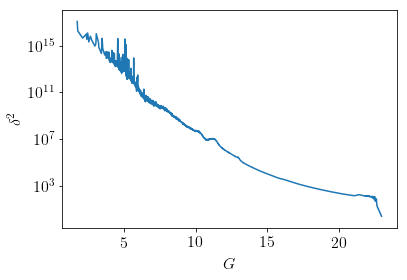

In [124]:
plt.plot(_magdata['magbin'], percentiles[1])
plt.fill_between(_magdata['magbin'], percentiles[0], percentiles[2], alpha=0.3)
plt.yscale('log'); plt.xlabel(r'$G$'); plt.ylabel(r'$\delta^2$')

Text(0, 0.5, '$\\delta^2$')

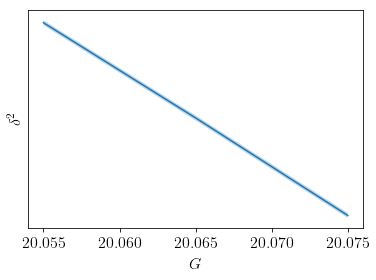

In [125]:
magrng = (_magdata['magbin']>20.05)&(_magdata['magbin']<20.08)
plt.plot(_magdata['magbin'][magrng], percentiles[1][magrng])
plt.fill_between(_magdata['magbin'][magrng], percentiles[0][magrng], percentiles[2][magrng], alpha=0.3)
plt.yscale('log'); plt.xlabel(r'$G$'); plt.ylabel(r'$\delta^2$')

## Modelling the flux scatter as a function of magnitude.

We can take the likelihood function given earlier and substitute $\delta^2$ for some function of $G$
$$\ln\mathcal{L} = \ln\left(\frac{f(G,a,b)}{2}\right)\sum_j \frac{N_j}{2} + \sum_j \left(\frac{N_j}{2}-1\right)\ln\left(\frac{1}{\epsilon_{Fj}^2}\right) - f(G,a,b)\sum_j\left(\frac{1}{2\epsilon_{Fj}^2}\right) - \sum_j \ln\Gamma\left(\frac{N_j}{2}\right).\\
\propto \frac{1}{2}\ln\left(\frac{f(G,a,b)}{2}\right)\sum_j N_j  - \frac{1}{2}f(G,a,b)\sum_j\left(\frac{1}{\epsilon_{Fj}^2}\right).$$
With this likelihood function, we can do MLE and estimate best fit parameters for $a,b$.

In [126]:
import emcee, tqdm, corner

In [127]:
def foo(G, a, b):
    return np.exp(a + b*G)

def lnlike(a, b, mag, n_sum, fprec_sum):
    
    return 0.5*np.sum( np.log(foo(mag, a, b)/2)*n_sum \
                            - foo(mag, a, b)   *fprec_sum)

In [128]:
magrng = (_magdata['magbin']>20)&(_magdata['magbin']<21)

# log likelihood
ll = lambda pars: lnlike(pars[0],pars[1],_magdata['magbin'][magrng],_magdata['n_sum'][magrng],_magdata['fprec_sum'][magrng])

In [129]:
ndim=2; nwalker=20; nstep=1000
p0_walkers=np.random.normal(np.array([1,1]), np.array([0.1,0.1]), size=(nwalker,2))

In [131]:
sampler = emcee.EnsembleSampler(nwalker, ndim, ll)
for pos,lnp,rstate in tqdm.tqdm_notebook(sampler.sample(p0_walkers, iterations=nstep), total=nstep):
    pass

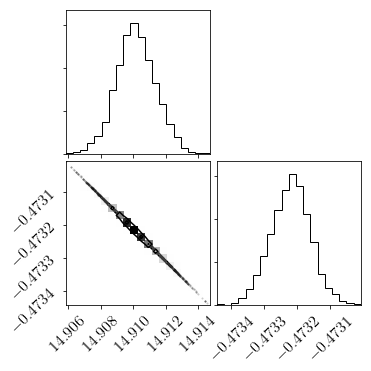

In [132]:
flatchain = sampler.chain[:,500:].reshape(-1,ndim)
corner.corner(flatchain);

Text(0, 0.5, '$\\delta^2$ (erg$^2$/s$^2$)')

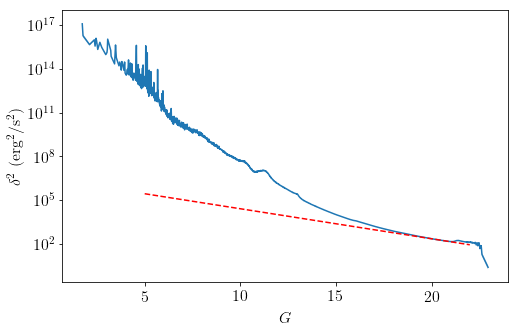

In [142]:
plt.figure(figsize=(8,5))
plt.plot(_magdata['magbin'], percentiles[1])
plt.fill_between(_magdata['magbin'], percentiles[0], percentiles[2], alpha=0.3)

x = np.linspace(5,22,1000)
fit = np.mean(flatchain,axis=0)
plt.plot(x, foo(x, fit[0], fit[1]), '--r')

plt.yscale('log'); plt.xlabel(r'$G$'); plt.ylabel(r'$\delta^2$ (erg$^2$/s$^2$)')
plt.save

Text(0, 0.5, '$\\delta^2$ (erg/s)')

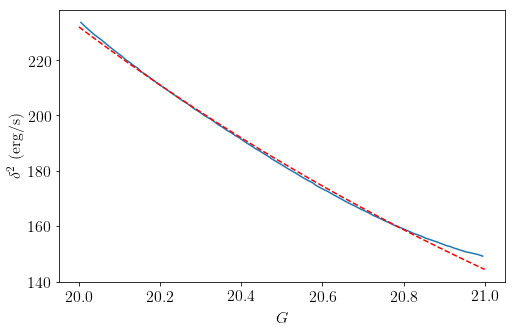

In [140]:
plt.figure(figsize=(8,5))
plt.plot(_magdata['magbin'][magrng], percentiles[1][magrng])
plt.fill_between(_magdata['magbin'][magrng], percentiles[0][magrng], percentiles[2][magrng], alpha=0.3)

x = np.linspace(20,21,100)
fit = np.mean(flatchain,axis=0)
plt.plot(x, foo(x, fit[0], fit[1]), '--r')
 
plt.xlabel(r'$G$'); plt.ylabel(r'$\delta^2$ (erg$^2$/s$^2$)')s